In [1]:
from model_gausian_2d_tf2 import *
from eval_utils import *
import time

2022-10-25 07:59:11.430421: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-25 07:59:14.125207: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-25 07:59:14.125294: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-25 07:59:25.051585: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
]
colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)
plt.rcParams["figure.figsize"] = (30, 6)

# Preprocessing

In [3]:
df_weather = pd.read_excel('../data/Dane_Uwr.xlsx', sheet_name='Do analizy')
df_main = pd.read_excel('../data/Dane_Uwr.xlsx', sheet_name='Surowe_hydraulika').ffill()

# Preprocessing
df_weather.drop(['Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19'], axis=1, inplace=True)
df_weather.columns = ['mtime', 'weekday', 'notes', 'volume',
       'flow rate', 'pressure',
       'tmax', 'tmin', 'tmean', 'tmin0', 'P',
       'P_positive', 'v', 'f', 'press', 'SD', 'RD']
df_main.columns = ['mtime', 'P1', 'V1', 'Q1']

In [4]:
df_weather.head()

,mtime,weekday,notes,volume,flow rate,pressure,tmax,tmin,tmean,tmin0,P,P_positive,v,f,press,SD,RD
0,2014-05-21,Wednesday,NaN,4144.0,172.617187,0.454444,27.3,9.6,19.5,6.9,0.0,0,3.4,65.0,1017.2,15.2,0.0
1,2014-05-22,Thursday,NaN,4037.0,169.533282,0.457605,28.1,14.1,21.4,11.6,0.0,0,6.0,62.9,1013.7,14.1,0.0
2,2014-05-23,Friday,NaN,3916.0,163.326628,0.457086,29.6,16.3,23.0,13.9,0.0,0,5.8,63.3,1009.9,13.6,0.8
3,2014-05-24,Saturday,NaN,4019.0,166.274963,0.455834,25.2,15.6,18.8,13.4,9.9,1,2.3,88.4,1013.4,2.9,7.5
4,2014-05-25,Sunday,NaN,3968.0,164.094300,0.457735,24.3,12.2,18.8,11.6,0.0,0,2.3,73.4,1019.5,13.4,0.0


In [5]:
df_main = df_main.ffill()
df_main.head()

,mtime,P1,V1,Q1
0,2014-05-20 16:20:00,0.484560,23.0,194.947052
1,2014-05-20 16:30:00,0.479604,52.0,218.519699
2,2014-05-20 16:40:00,0.465498,84.0,160.275650
3,2014-05-20 16:50:00,0.478460,116.0,196.656509
4,2014-05-20 17:00:00,0.478841,147.0,198.737137


In [6]:
interval = 24 * 7 * 6
df_main["V_delta"] = np.array([0] + (df_main.V1[1:].values - df_main.V1[:-1].values).tolist())

df_main.loc[(df_main.V_delta.abs() > 50), "V_delta"] = 30  # df_main.loc[(df_main.V_delta.abs() < 50), "V_delta"].mean()
df_main["V_delta"] = df_main["V_delta"].rolling(6, center=True, min_periods=2).mean()

time_range = pd.DataFrame({"mtime": pd.date_range(df_main.loc[(df_main.mtime.dt.year == 2018) & (df_main.mtime.dt.month == 3), :].mtime.min(),
                                                  df_main.loc[(df_main.mtime.dt.year == 2020) & (df_main.mtime.dt.month == 2) & (df_main.mtime.dt.day == 28), :].mtime.max(), 24*6*(365+365))})
df_main = pd.merge(time_range, df_main, on="mtime", how="left")
df_main["V_delta"] = (df_main["V_delta"].bfill().ffill() + df_main["V_delta"].ffill().bfill()) / 2

df_main["V_delta_der"] = np.concatenate([np.array([0]), np.array([df_main["V_delta"].values[1] - df_main["V_delta"].values[0]]),
                                         df_main["V_delta"].values[2:] - df_main["V_delta"].values[:-2] / 2 - df_main["V_delta"].values[1:-1] / 2])

seasonal_changes = df_main.V_delta.rolling(interval * 6, center=True, min_periods=2).mean() \
    .rolling(interval, center=True, min_periods=2).mean()

data = df_main.loc[:, ['V_delta']]
data.V_delta = data.V_delta - seasonal_changes

data_train = data[df_main.mtime < df_main.loc[((df_main.mtime.dt.year == 2019) & (df_main.mtime.dt.month == 3)), 'mtime'].min()]
data_test = data[df_main.mtime >= df_main.loc[((df_main.mtime.dt.year == 2019) & (df_main.mtime.dt.month == 3)), 'mtime'].min()]

lengths = np.array([interval for _ in range(data_train.shape[0] // (interval))] + [
    data_train.shape[0] - (data_train.shape[0] // (interval)) * interval])
Y = data_train.values.reshape(-1, 1)

lengths_test = np.array([interval for _ in range(data_test.shape[0] // (interval))] + [
    data_test.shape[0] - (data_test.shape[0] // (interval)) * interval])
Y_test = data_test.values.reshape(-1, 1)

# target = pd.Series(pd.date_range(df_main.loc[(df_main.mtime.dt.year == 2018) & (df_main.mtime.dt.month == 3), :].mtime.dt.floor('d').min(),
#                                  df_main.loc[(df_main.mtime.dt.year == 2019) & (df_main.mtime.dt.month == 2), :].mtime.dt.floor('d').max(),
#                                  365)).apply(lambda d: (d in holidays.PL()) | (d.weekday() > 4))
#
# target_test = pd.Series(pd.date_range(df_main.loc[(df_main.mtime.dt.year == 2019) & (df_main.mtime.dt.month == 3), :].mtime.dt.floor('d').min(),
#                                       df_main.loc[(df_main.mtime.dt.year == 2020) & (df_main.mtime.dt.month == 2) & (df_main.mtime.dt.day == 28), :].mtime.dt.floor('d').max(),
#                                       365)).apply(lambda d: (d in holidays.PL()) | (d.weekday() > 4))
#
# target_w = pd.Series(pd.date_range(df_main.loc[(df_main.mtime.dt.year == 2018) & (df_main.mtime.dt.month == 3), :].mtime.dt.floor('d').min(),
#                                    df_main.loc[(df_main.mtime.dt.year == 2019) & (df_main.mtime.dt.month == 2), :].mtime.dt.floor('d').max(),
#                                    365)).apply(
#     lambda d: 7 if d in holidays.PL() else d.weekday())
#
# target_w_test = pd.Series(pd.date_range(df_main.loc[(df_main.mtime.dt.year == 2019) & (df_main.mtime.dt.month == 3), :].mtime.dt.floor('d').min(),
#                                         df_main.loc[(df_main.mtime.dt.year == 2020) & (df_main.mtime.dt.month == 2) & (df_main.mtime.dt.day == 28), :].mtime.dt.floor('d').max(),
#                                         365)).apply(
#     lambda d: 7 if d in holidays.PL() else d.weekday())

In [7]:
# df_main["V_delta"] = np.array([0] + (df_main.V1[1:].values - df_main.V1[:-1].values).tolist())
# df_main.loc[(df_main.V_delta.abs() > 1e+3), "V_delta"] = 0  # TODO: why 0?

In [8]:
# plt.plot(df_main.mtime[df_main.mtime.dt.year == 2019],
#          df_main.V_delta.rolling(6*24*28, center=True, min_periods=2).mean().rolling(6*24*7, center=True, min_periods=2).mean()[df_main.mtime.dt.year == 2019],
#          color="grey")
#
# plt.plot(df_weather.mtime[df_weather.mtime.dt.year == 2019],
#          (df_weather.loc[df_weather.mtime.dt.year == 2019, "notes"] == "Holiday").astype(int)*4 + 16,
#          color="red")
#
# plt.plot(df_main.mtime[df_main.mtime.dt.year == 2019],
#          df_main.V_delta.rolling(6*24*7, center=True, min_periods=2).mean()[df_main.mtime.dt.year == 2019])
#
#
# plt.plot(df_main.mtime[df_main.mtime.dt.year == 2019],
#          df_main.V_delta.rolling(6*24, center=True, min_periods=2).mean()[df_main.mtime.dt.year == 2019],
#         color="black")
#
# plt.show()

In [9]:
# seasonal_changes=df_main.V_delta.rolling(6*24*42, center=True, min_periods=2).mean().rolling(6*24*7, center=True, min_periods=2).mean()[df_main.mtime.dt.year == 2019]
# data = df_main.V_delta.rolling(24*5, center=True, min_periods=2).mean()[df_main.mtime.dt.year == 2019] - seasonal_changes

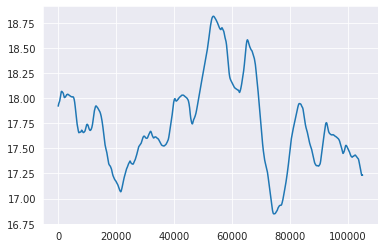

In [10]:
plt.plot(seasonal_changes)

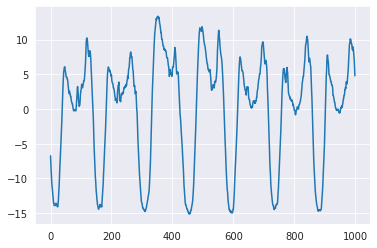

In [11]:
plt.plot(data[:1000])

In [12]:
# plt.plot(data.rolling(6*24*28, center=True, min_periods=2).mean())

In [13]:
# data.shape

In [14]:
# data.shape[0] / (24*7*6)

In [15]:
# lengths = np.array([24*7*6 for _ in range(data.shape[0] // (24*7*6))] +  [data.shape[0] - (data.shape[0] // (24*7*6)) * 24*7*6])

In [16]:
# Y = data.values.reshape(-1,  1)

In [17]:
# T = 24*7*6
# s = data.shape[0] // (24*7*6) + 1

#  Model training

In [18]:
n = 10
l = 3
lr = 0.3
ITER = 100
TOLERANCE = 1e-4

def em_scheduler(max_lr, it):
    if it <= np.ceil(2 * ITER / 3):
        return max_lr * np.cos((np.ceil(ITER * 2 / 3) - it) / ITER * np.pi * .67)
    else:
        return max_lr * np.cos(3 * (np.ceil(ITER * 2 / 3) - it) * np.pi * .33 / ITER)  ** 3


mstep_cofig = {"cooc_lr": lr, "cooc_epochs": 10000, "l_uz": l,
               'loss_type': 'square', "scheduler": em_scheduler}

t = time.localtime()

true_values = None

wandb_params = {
    "init": {
        "project": "gaussian-dense-hmm-wodociagi",
        "entity": "cirglaboratory",
        "save_code": True,
        "group": f"first-runs-2",
        "job_type": f"{t.tm_year}-{t.tm_mon}-{t.tm_mday}",
        "name": f"test3",
        "reinit": True
    },
    "config": {
        "n": n,
        "s": interval,
        "T": 53,
        "model": None,
        "m": None,
        "l": None,
        "lr": lr,
        "em_epochs": None,
        "em_iter": None,
        "cooc_epochs": ITER,
        "simple_model": None
    }
}


mstep_cofig = {"cooc_lr": lr, "cooc_epochs": ITER, "l_uz": l,
               'loss_type': 'square', "scheduler": em_scheduler}

hmm_monitor = HMMLoggingMonitor(tol=TOLERANCE, n_iter=0, verbose=True,
                                wandb_log=True, wandb_params=wandb_params, true_vals=true_values,
                                log_config={'metrics_after_convergence': True})
densehmm = GaussianDenseHMM(n, mstep_config=mstep_cofig,
                            covariance_type='full', opt_schemes={"cooc"},
                            # nodes=np.concatenate([np.array([-np.infty]), nodes]),
                            em_iter=20,
                            logging_monitor=hmm_monitor,
                            init_params="stmc", params="stmc", early_stopping=True)
# densehmm.means_ = mu.reshape(-1, 1)
start = time.perf_counter()
# densehmm.fit_coocs(Y,lengths)
densehmm.fit(Y, lengths)
time_tmp = time.perf_counter() - start

wandb: Currently logged in as: kabalce (cirglaboratory). Use `wandb login --relogin` to force relogin


2022-10-25 08:00:26.529419: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-25 08:00:26.530777: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-25 08:00:26.530806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cymestmp): /proc/driver/nvidia/version does not exist
2022-10-25 08:00:26.537120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Fit model:   0%|                                         | 0/20 [00:00<?, ?

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


         1     -187601.0630             +nan
Fit model: 100%|████████████████████████████████| 20/20 [08:30<00:00, 25.55s/it]


# Evaluation

In [19]:
densehmm = GaussianDenseHMM(n, mstep_config=mstep_cofig,
                            covariance_type='full', opt_schemes={"cooc"},
                            # nodes=np.concatenate([np.array([-np.infty]), nodes]),
                            em_iter=20,
                            logging_monitor=hmm_monitor,
                            init_params="stmc", params="stmc", early_stopping=True)
# densehmm.means_ = mu.reshape(-1, 1)
start = time.perf_counter()
densehmm.fit_coocs(Y,lengths)
# densehmm.fit(Y, lengths)
time_tmp = time.perf_counter() - start

        21     -181549.1433      -26924.4516


In [20]:
from sklearn.decomposition import PCA
import multiprocessing as mp
from celluloid import Camera
import matplotlib.cm as cm
from IPython.display import display, Markdown, Latex, HTML

In [22]:
# # draw embeddings movement
# z_init = np.transpose(hmm_monitor.z[-1])
# pca_z = PCA(n_components=2).fit(z_init)
# z = [pca_z.transform(z_init)] + [pca_z.transform(np.transpose(x)) for x in hmm_monitor.z]
#
# z0 = list(hmm_monitor.z0)
#
# u_init = hmm_monitor.u[-1]
# pca_u = PCA(n_components=2).fit(u_init)
# u = [pca_u.transform(u_init)] + [pca_u.transform(x) for x in hmm_monitor.u]


In [23]:
# import wandb
#
#
# def draw_embeddings(z, name="?"):
#     fig = plt.figure(figsize=(5, 5))
#     camera = Camera(fig)
#     cmap = cm.rainbow(np.linspace(0, 1, len(z[0])))
#     for z_el in z:
#         if z_el.shape[1] > 1:
#             plt.scatter(z_el[:, 0],  z_el[:, 1], color=cmap)
#         else:
#             plt.scatter(np.arange(z_el.shape[0]), z_el, color=cmap)
#         camera.snap()
#     plt.title(f"Embaddings trajectory:  {name}")
#     animation = camera.animate().to_html5_video()
#     # wandb.log({f"Embaddings trajectory:  {name}": wandb.Html(animation)})
#     display(HTML(animation))
#     plt.close()

In [26]:
# draw_embeddings(z, "z")
# draw_embeddings(z0,"z0")
# draw_embeddings(u, "u")

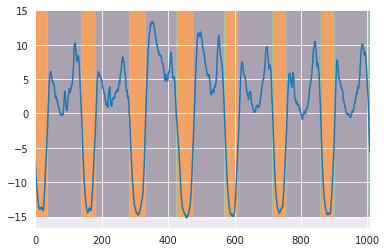

In [27]:
# visualize states
X = densehmm.predict(Y)

plt.imshow(X.reshape(1, -1)[:, :(24*7*6)], aspect="auto", alpha=0.6, extent=(0, 24*7*6, -15, 15) , cmap=cmap)
plt.plot(Y[:(24*7*6), 0])
plt.show()

In [ ]:
# visualize nodes

In [ ]:
# compare to hmmlearn

In [ ]:
# # save data for hyper-parameter tuning
# import json
# with open("../data/wodociagi.json",  "w") as f:
#     json.dump(Y.tolist(), f, indent=4)